In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import jax

from src.simulate_trace import MakeTrace, apply_noise, GaussianAmplitude, PolynomialPhase, MultiPulse, RandomPhase

/home/tillstehling/miniconda3/lib/python3.11/site-packages/refractiveindex/refractiveindex.py:300: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(nsq)


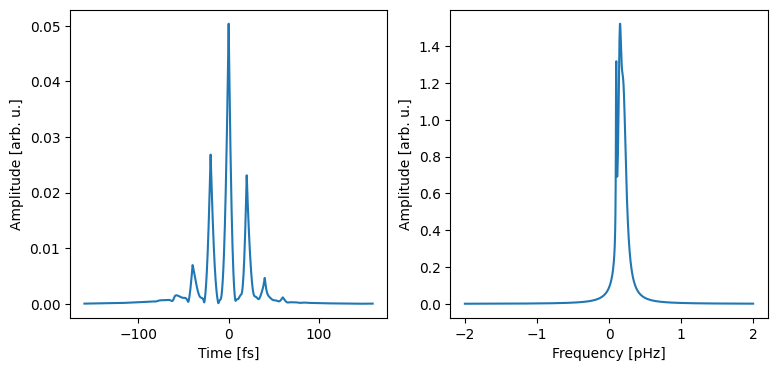

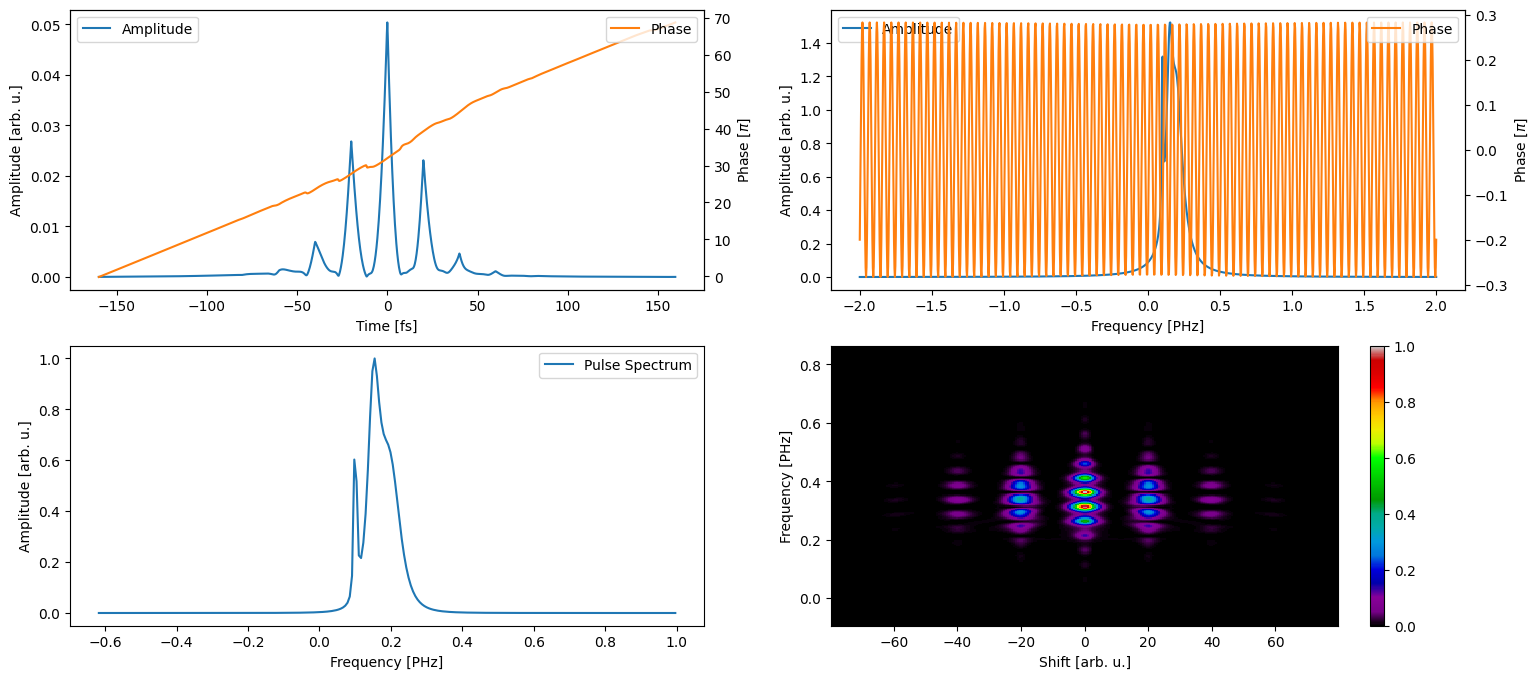

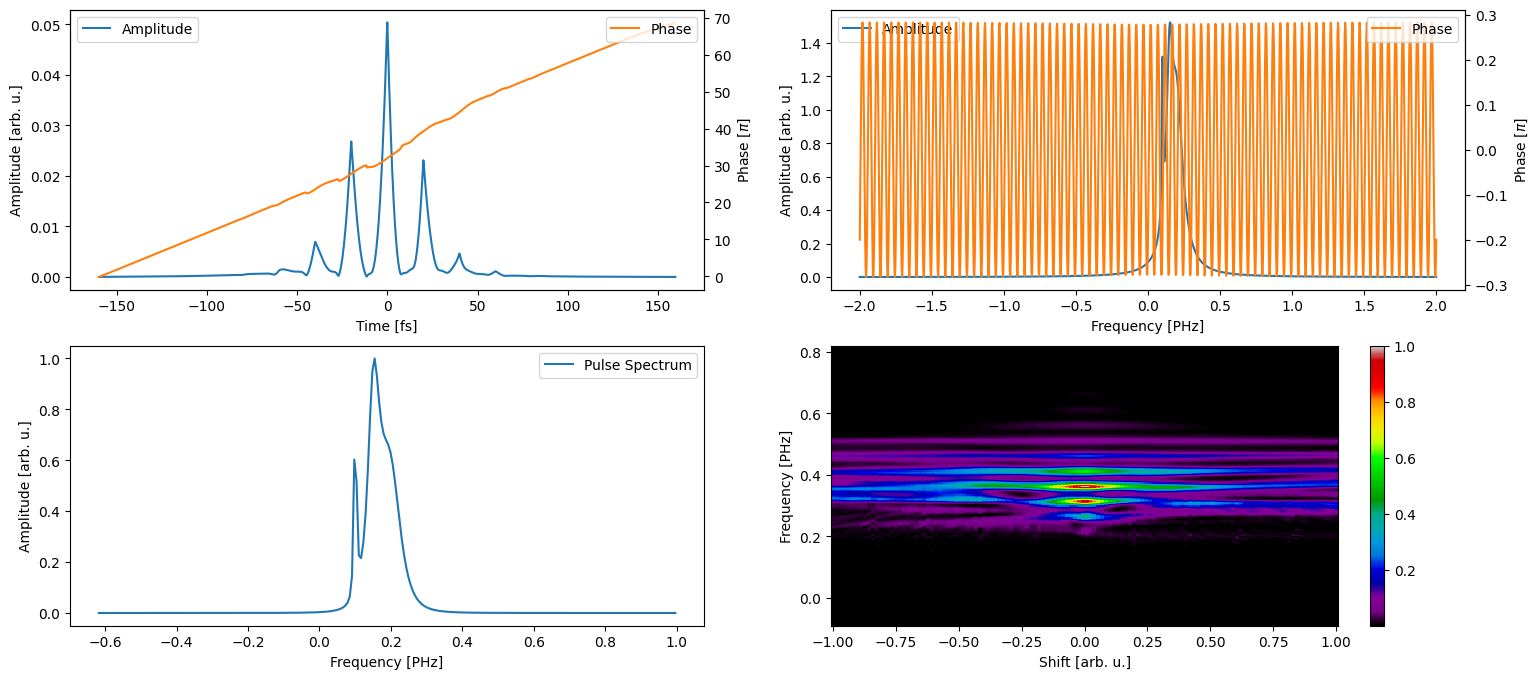

In [ ]:
from src.simulate_trace import MakeTrace, apply_noise
from src.simulate_trace import GaussianAmplitude, LorentzianAmplitude, PolynomialPhase, SinusoidalPhase, RandomPhase, MultiPulse
import jax.numpy as jnp

amp0 = GaussianAmplitude((1,1,1), (0.1,0.15,0.2), (0.01,0.05,0.1), (1,1,1))
amp1 = LorentzianAmplitude((1,1,1), (0.1,0.15,0.2), (0.01,0.05,0.1), (1,1,1))
phase0 = PolynomialPhase(None, (0,0,50,-25))
phase1 = SinusoidalPhase((0.1,0.1), (0.1,0.2), (20,20), (0, jnp.pi/2))
phase2 = RandomPhase()

pulse = MultiPulse(("G","G","L"), (1,1,1), (50,50), (25,25,25), (0.25,0.25,0.3), (1,2,3), (phase1, phase2, phase2))


mp = MakeTrace(N=128*10, f_max=2)

time, pulse_t, frequency, pulse_f = mp.generate_pulse((amp1,phase1))
#time, pulse_t, frequency, pulse_f = mp.generate_pulse(pulse) # in case of MultiPulse
mp.plot_envelopes()



delay, frequency_trace, trace, spectra = mp.generate_frog(time, frequency, pulse_t, pulse_f, "shg")



import refractiveindex
phase_type = "material"
parameters = refractiveindex.RefractiveIndexMaterial(shelf="main", book="SiO2", page="Malitson")
z_arr = jnp.linspace(-1,1,128)

z_arr, frequency_trace, trace, spectra = mp.generate_chirpscan(time, frequency, pulse_t, pulse_f, "shg", z_arr, phase_type, parameters)

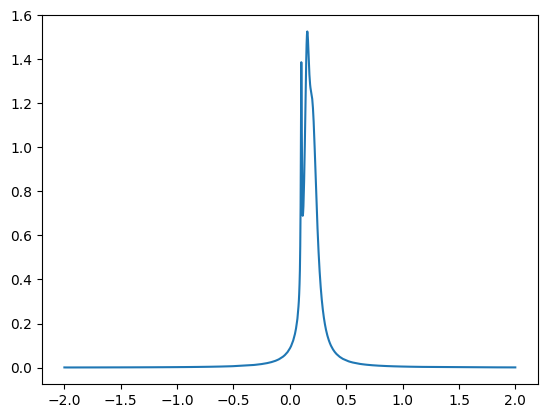

In [10]:
plt.plot(frequency, jnp.abs(jnp.fft.fftshift(jnp.fft.fft(pulse_t))))

In [11]:
mp.maketrace.signal_t

MyNamespace(signal_t: [shape=(128, 1280), dtype(complex64)], signal_f: [shape=(128, 1280), dtype(complex64)], pulse_t_disp: [shape=(128, 1280), dtype(complex64)], gate_disp: [shape=(128, 1280), dtype(float32)])

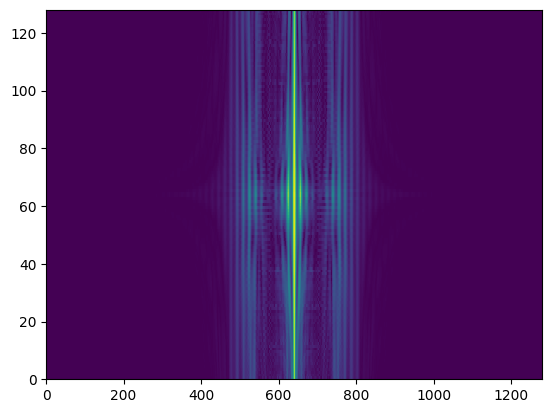

In [19]:
plt.pcolormesh(jnp.abs(jnp.fft.fftshift(jnp.fft.fft(mp.maketrace.signal_t.signal_t,axis=-1),axes=-1)))

In [3]:
import matplotlib.pyplot as plt

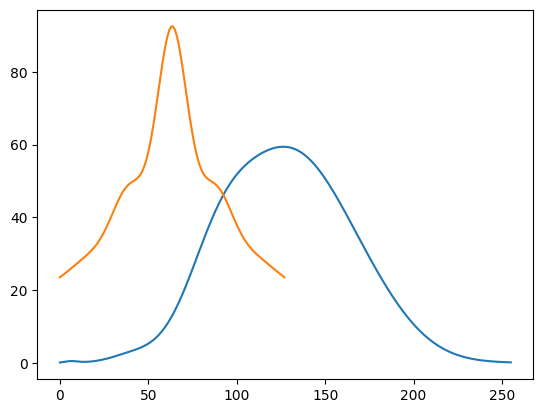

In [12]:
plt.plot(jnp.sum(trace,axis=0))
plt.plot(jnp.sum(trace,axis=1))

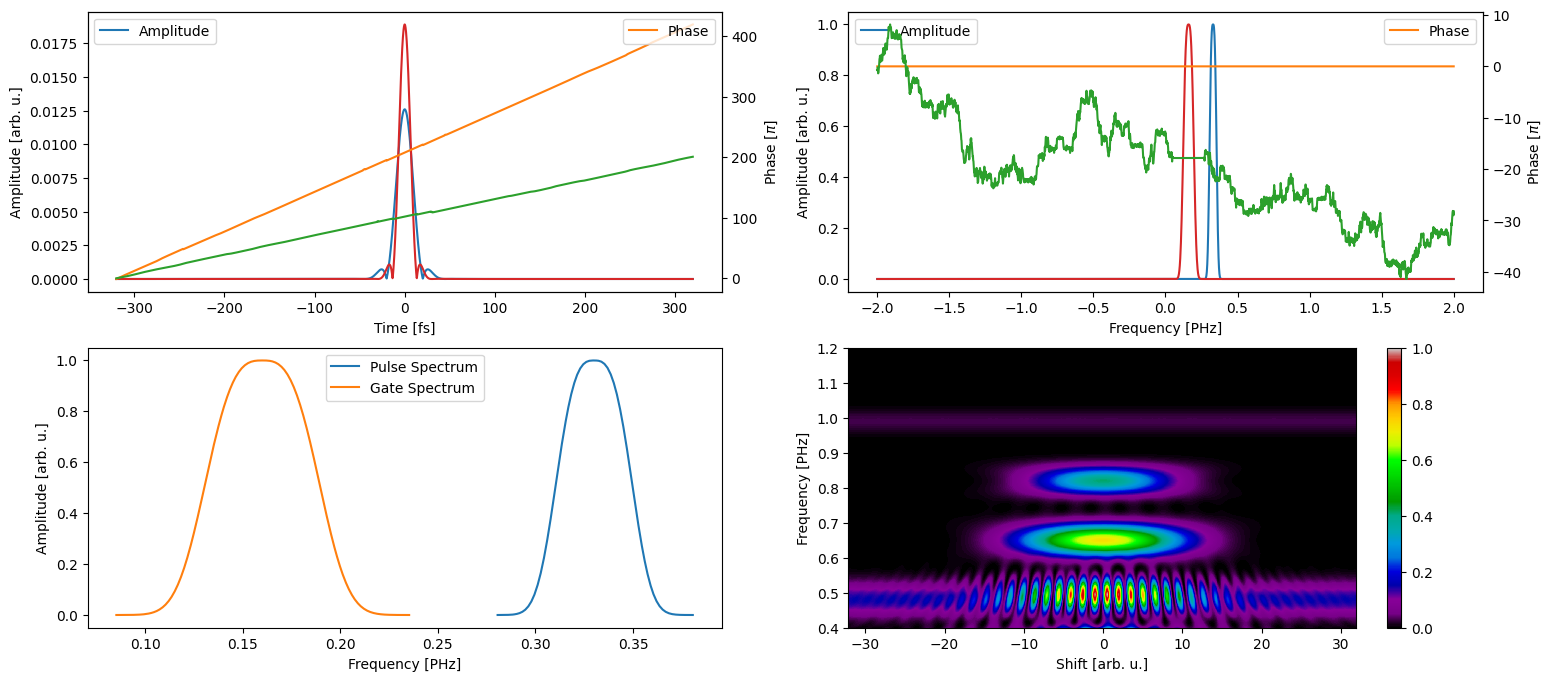

In [ ]:
pulse_maker = MakeTrace(N=128*20, Delta_f=2)

phase = PolynomialPhase(None, (0,0,0,0))
amp = GaussianAmplitude((1), (0.33), (0.05), (1.5))
time_inp, pulse_t_inp, frequency_inp, pulse_f_inp = pulse_maker.generate_pulse((amp, phase))


input_pulses = pulse_maker.pulses


# phase = PolynomialPhase(0.3, (0,0,30,0))
# amp = GaussianAmplitude((1,1), (0.225,0.2), (0.01,0.025), (1,1))
phase = PolynomialPhase(None, (0.5,0,0,0))
amp = GaussianAmplitude((1), (0.16), (0.075), (1.5))
_, _, frequency_gate, pulse_f_gate = pulse_maker.generate_pulse((amp, phase))


delay, frequency, trace, spectra=pulse_maker.generate_frog(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, "3hg", cross_correlation=True, interferometric=True,
                                                          gate=(frequency_gate, pulse_f_gate), real_fields=True, interpolate_fft_conform=False,
                                                          N=128*8, scale_time_range=0.1, plot_stuff=True, cut_off_val=0.0001, frequency_range=(0.4,1.2))

In [ ]:
trace_0 = jnp.copy(trace)

In [ ]:
trace_1 = jnp.copy(trace)

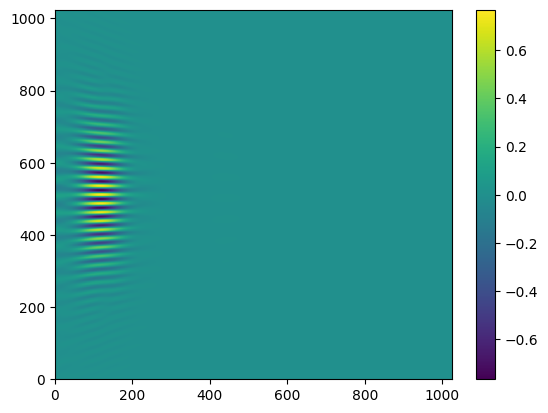

In [ ]:
plt.pcolormesh(trace_0-trace_1)
plt.colorbar()